In [182]:
import numpy as np
import torch.utils.data
import torchvision.utils
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import umap.umap_ as umap
import sklearn.datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import idx2numpy
from PIL import Image
from sklearn import preprocessing
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import KerasClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from art.estimators.classification import PyTorchClassifier

In [183]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)
        self.conv_2 = nn.Conv2d(in_channels=4, out_channels=10, kernel_size=5, stride=1)
        self.fc_1 = nn.Linear(in_features=4 * 4 * 10, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv_2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 10)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


In [184]:
fashion = sklearn.datasets.fetch_openml('Fashion-MNIST')

fashion_df = pd.DataFrame(fashion.data)
fashion_df['fashion'] = pd.Series(fashion.target)


In [185]:
fashion_df = fashion_df.iloc[:,0:784]
fashion_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,119.0,114.0,130.0,76.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,96.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [252]:
x_train, x_test, y_train, y_test = train_test_split(fashion_df, fashion.target, test_size=0.4)

In [253]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

In [255]:
x_train = x_train.reshape(42000, 1, 28, 28)
x_test = x_test.reshape(28000, 1, 28, 28)

In [256]:
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [257]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0.0, 1.0),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)


In [258]:
# Step 4: Train the ART classifier

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

In [259]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 80.16785714285714%


In [260]:
y_pred = np.argmax(predictions, axis=1)

In [261]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier, eps=0.5)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 79.30714285714285%


In [262]:
y_pred_attack = np.argmax(predictions, axis=1)

In [263]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)
cm_attack = confusion_matrix(y_test, y_pred_attack)

In [264]:
label_names = ["T-shirt/top",
               "Trouser",
               "Pullover",
               "Dress",
               "Coat",
               "Sandal",
               "Shirt",
               "Sneaker",
               "Bag",
               "Ankle boot"]

In [265]:
# Creating a dataframe cm
cm_df = pd.DataFrame(cm, index = label_names, columns = label_names)
cm_df_attack = pd.DataFrame(cm_attack, index = label_names, columns = label_names)

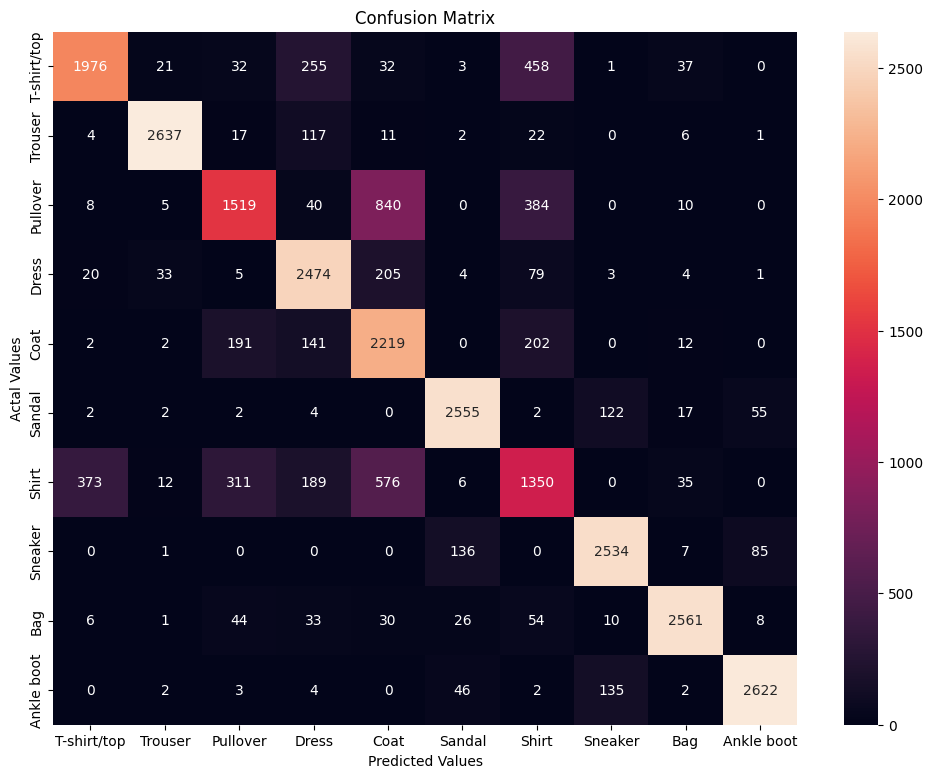

In [266]:
#Plotting the confusion matrix
plt.figure(figsize=(12,9))
sns.heatmap(cm_df, annot=True, fmt ='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

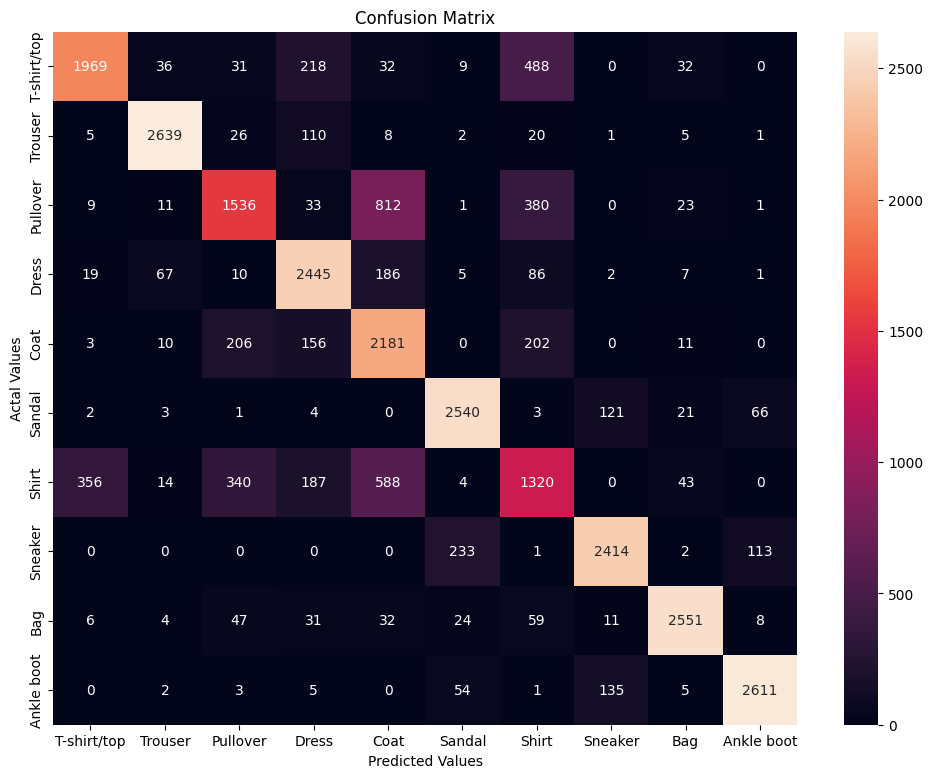

In [267]:
plt.figure(figsize=(12,9))
sns.heatmap(cm_df_attack, annot=True, fmt ='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Accuracy on adversarial test examples: 82.63571428571429%


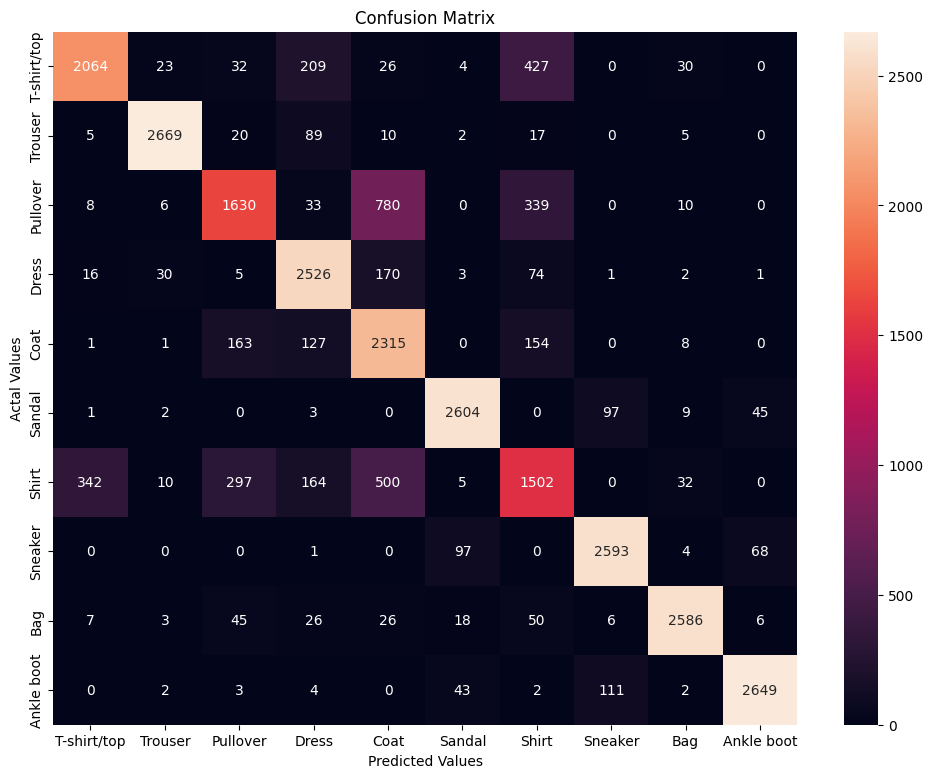

In [268]:
# Step 6: Generate adversarial test examples
attack = FastGradientMethod(estimator=classifier,targeted = True)
x_test_adv = attack.generate(x=x_test, y=y_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

y_pred_attack2 = np.argmax(predictions, axis=1)

cm_attack2 = confusion_matrix(y_test, y_pred_attack2)

cm_df_attack = pd.DataFrame(cm_attack2, index = label_names, columns = label_names)

plt.figure(figsize=(12,9))
sns.heatmap(cm_df_attack, annot=True, fmt ='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [269]:
from art.attacks.evasion import DeepFool
attack = DeepFool(classifier)
x_test_adv = attack.generate(x=x_test)

# Step 7: Evaluate the ART classifier on adversarial test examples

predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

DeepFool:   0%|          | 0/28000 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 9.903571428571428%


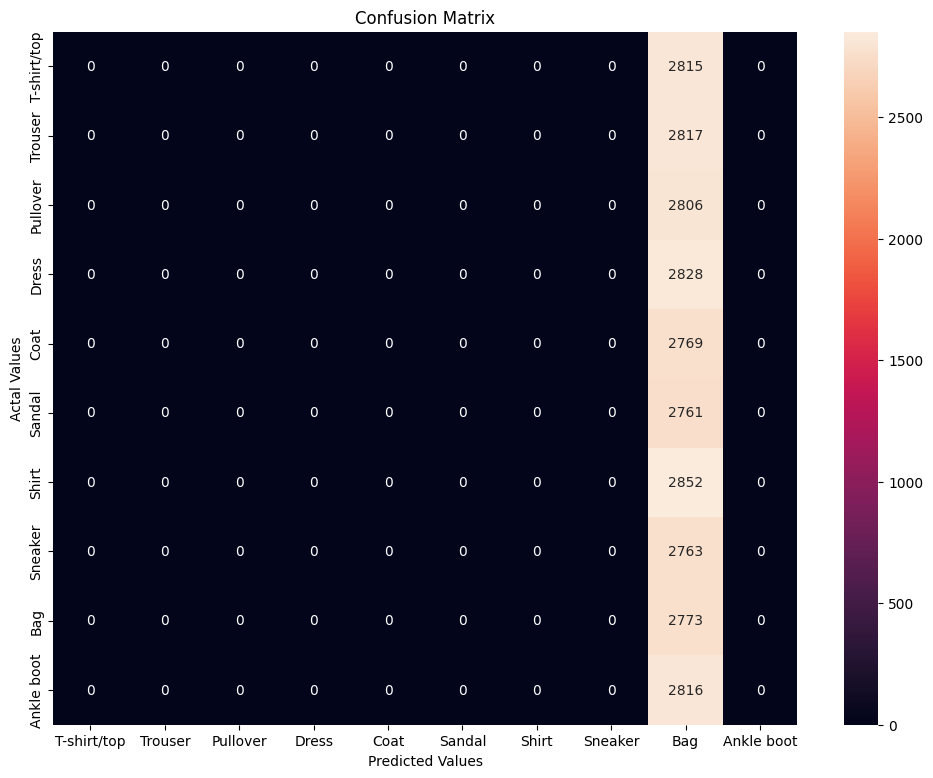

In [270]:
y_pred_attack_deepfool = np.argmax(predictions, axis=1)

cm_attack_deepfool = confusion_matrix(y_test, y_pred_attack_deepfool)

cm_df_attack_deepfool = pd.DataFrame(cm_attack_deepfool, index = label_names, columns = label_names)

plt.figure(figsize=(12,9))
sns.heatmap(cm_df_attack_deepfool, annot=True, fmt ='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()